In [18]:
import polars as pl
import numpy as np
from datetime import datetime,timedelta
import random

# Pytorch for ML

import torch
import torch.nn as nn
import torch.optim as optim
import research

#visualization
import altair as alt

#data
import binance

import importlib
importlib.reload(research)
importlib.reload(binance)

<module 'binance' from '/Users/ujjawalpratapsingh/Documents/quant-strategy/binance.py'>

In [2]:
research.set_seed(42)

In [3]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)

polars.config.Config

In [4]:
sym = 'BTCUSDT'

hist_data_window = 7 * 4 * 6

time_interval = '1h'

max_lags = 4

forecast_horizon = 1

annualized_rate = research.sharpe_annualization_factor(time_interval, 365,24)

In [5]:
binance.download_trades(sym,hist_data_window)

downloading BTCUSDT: 100%|██████████| 168/168 [00:02<00:00, 57.11it/s]


In [6]:
ts = research.load_ohlc_timeseries(sym,time_interval)
ts

Loading BTCUSDT: 100%|██████████| 392/392 [00:22<00:00, 17.32file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-09-25 00:00:00,64243.2,64410.0,63955.9,64090.1
2024-09-25 01:00:00,64090.2,64800.0,64051.7,64355.0
2024-09-25 02:00:00,64355.1,64533.0,64253.4,64390.0
2024-09-25 03:00:00,64390.0,64433.3,64191.8,64422.4
2024-09-25 04:00:00,64422.5,64430.0,64140.0,64142.3
…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6


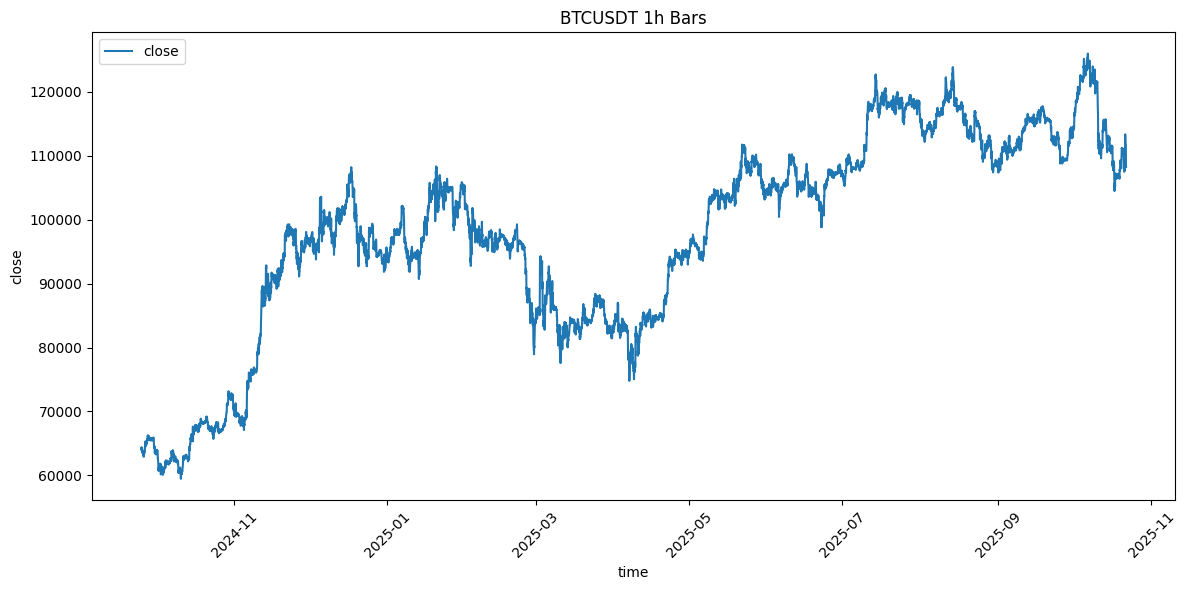

In [7]:
research.plot_static_timeseries(ts,sym,'close',time_interval)

In [10]:
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym,'close',time_interval)

alt.Chart(...)

In [12]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))

In [13]:
target = 'close_log_return'
ts = research.add_lags(ts,target, max_lags,forecast_horizon)

In [ ]:
ts = ts.drop_nulls()

datetime,open,high,low,close,close_log_return,col_lag_1,col_lag_2,col_lag_3,col_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-25 00:00:00,64243.2,64410.0,63955.9,64090.1,null,null,null,null,null
2024-09-25 01:00:00,64090.2,64800.0,64051.7,64355.0,0.004125,null,null,null,null
2024-09-25 02:00:00,64355.1,64533.0,64253.4,64390.0,0.000544,0.004125,null,null,null
2024-09-25 03:00:00,64390.0,64433.3,64191.8,64422.4,0.000503,0.000544,0.004125,null,null
2024-09-25 04:00:00,64422.5,64430.0,64140.0,64142.3,-0.004357,0.000503,0.000544,0.004125,null
…,…,…,…,…,…,…,…,…,…
2025-10-21 19:00:00,111934.5,112147.4,111501.7,111720.7,-0.001912,-0.000229,-0.004875,-0.007509,0.01089
2025-10-21 20:00:00,111720.7,111747.7,110468.0,110733.0,-0.00888,-0.001912,-0.000229,-0.004875,-0.007509
2025-10-21 21:00:00,110733.0,111068.7,110016.3,110772.6,0.000358,-0.00888,-0.001912,-0.000229,-0.004875


In [19]:
research.plot_distribution(ts, target, no_bins = 200)

alt.Chart(...)

In [21]:
research.plot_distribution(ts, 'close', no_bins = 200)

alt.Chart(...)